In [ ]:
# Specify the path to your zip file
zip_file_path = '/content/archive.zip'

# Unzip the file into the current directory
import zipfile

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:

# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from PIL import Image
import time
import torch
from torch.optim import lr_scheduler
from torch import nn,optim
import torch.backends.cudnn as cudnn
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader,Dataset
from torchvision.utils import make_grid
cudnn.benchmark = True
plt.ion()   # interactive mode
from tempfile import TemporaryDirectory

In [ ]:
import torch
from torch.optim import lr_scheduler
from torch import nn, optim
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from PIL import Image
import time
from tempfile import TemporaryDirectory

In [ ]:
cudnn.benchmark = True
plt.ion()  # interactive mode
# Define paths to dataset directories
aidata = "/content/AiArtData/AiArtData"
realdata = "/content/RealArt/RealArt"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define a custom dataset class inheriting from PyTorch's Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = Image.open(self.X[idx])
        img = img.convert("RGB")
        label = self.y[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
# Define data transformations for training and validation sets
data_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [ ]:
# Define a function to create a DataFrame with image file paths, labels, and modes
def make_label(class_1: list, class_2: list):
    class_1_name, class_1_dir = class_1
    class_2_name, class_2_dir = class_2
    label_ = []
    img_file = []
    mode = []
    # Function to check if the image file is valid
    def check(ext, img_path, mode):
        if ext in [".jpg", '.jpeg', '.png'] and os.path.exists(img_path) and mode in ["RGB", "RGBA"]:
            return True
        return False

    for i in os.listdir(class_1_dir):
        _, m = os.path.splitext(i)
        path = os.path.join(class_1_dir, i)
        im = Image.open(path)
        if not check(m, path, im.mode):
            continue
        img_file.append(path)
        mode.append(m)
        label_.append(class_1_name)

    for i in os.listdir(class_2_dir):
        _, m = os.path.splitext(i)
        path = os.path.join(class_2_dir, i)
        im = Image.open(path)
        md = im.mode
        if not check(m, path, md):
            continue
        img_file.append(path)
        mode.append(m)
        label_.append(class_2_name)
     # Create DataFrame from collected data
    return pd.DataFrame({'img_file': img_file, 'label': label_, 'mode': mode})

df = make_label([0, aidata], [1, realdata])

from sklearn.model_selection import train_test_split

X = df['img_file'].values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
# Create datasets and dataloaders for training and validation sets
image_datasets = {'train': CustomDataset(X=X_train, y=y_train, transform=data_transform['train']),
                  'val': CustomDataset(X=X_test, y=y_test, transform=data_transform['val'])}

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=4, num_workers=2, shuffle=True),
               'val': DataLoader(image_datasets['val'], batch_size=4, num_workers=2)}
# Define class names for visualization
class_names = {0: 'Ai Image', 1: 'Real Image'}

# Define a function to display images
def imshow(inp, title=None):
    plt.figure(figsize=(10, 5))
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


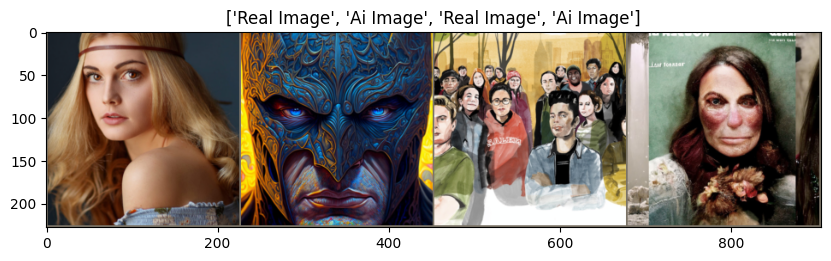

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))
classes = classes.tolist()

# Make a grid from batch
out = make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    acc_ = {'train': [], 'val': []}
    loss_ = {'train': [], 'val': []}

    # Define dataset sizes
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                acc_[phase].append(epoch_acc)
                loss_[phase].append(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, acc_, loss_

In [ ]:

# Define a new model architecture (e.g., ResNet-50)
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

# Define a new optimizer with a lower learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Define a new learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Train the model with more epochs
model_ft, acc, loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)



Epoch 0/49
----------
train Loss: 0.6827 Acc: 0.5545
val Loss: 0.5878 Acc: 0.6755

Epoch 1/49
----------
train Loss: 0.6025 Acc: 0.6423
val Loss: 0.5352 Acc: 0.7234

Epoch 2/49
----------
train Loss: 0.5932 Acc: 0.6795
val Loss: 0.5329 Acc: 0.7074

Epoch 3/49
----------
train Loss: 0.5398 Acc: 0.7181
val Loss: 0.4978 Acc: 0.7394

Epoch 4/49
----------
train Loss: 0.5503 Acc: 0.7168
val Loss: 0.4696 Acc: 0.7819

Epoch 5/49
----------
train Loss: 0.5383 Acc: 0.7221
val Loss: 0.5573 Acc: 0.6755

Epoch 6/49
----------
train Loss: 0.4880 Acc: 0.7673
val Loss: 0.4455 Acc: 0.7872

Epoch 7/49
----------
train Loss: 0.4848 Acc: 0.7726
val Loss: 0.4345 Acc: 0.8245

Epoch 8/49
----------
train Loss: 0.4559 Acc: 0.7992
val Loss: 0.4523 Acc: 0.7713

Epoch 9/49
----------
train Loss: 0.4743 Acc: 0.7859
val Loss: 0.4819 Acc: 0.7553

Epoch 10/49
----------
train Loss: 0.4797 Acc: 0.7606
val Loss: 0.4576 Acc: 0.7660

Epoch 11/49
----------
train Loss: 0.4861 Acc: 0.7713
val Loss: 0.4801 Acc: 0.7606

Ep

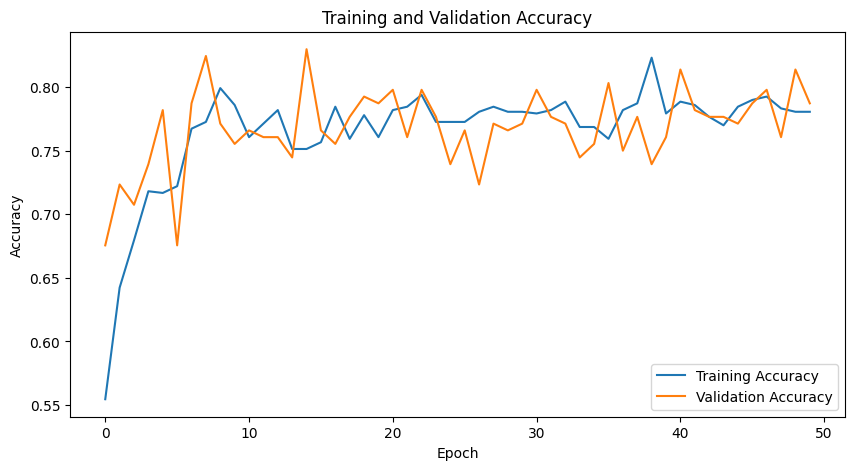

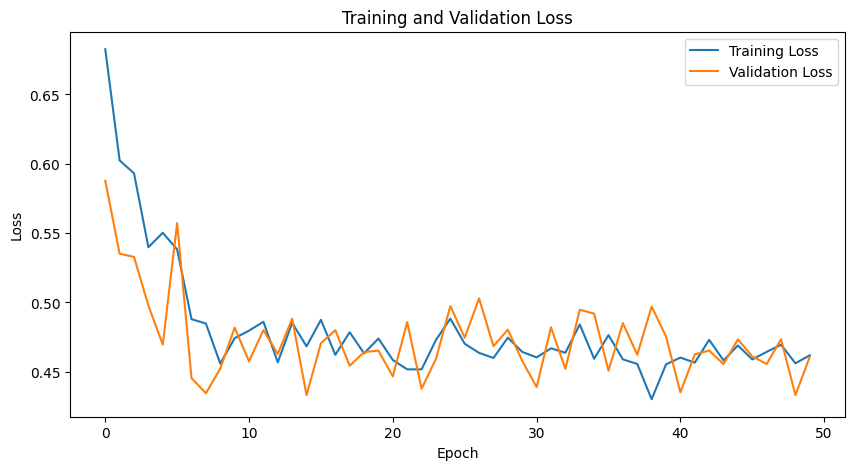

In [ ]:
# Convert the lists to tensors and move them to CPU
acc_train = torch.tensor(acc['train']).cpu()
acc_val = torch.tensor(acc['val']).cpu()
loss_train = torch.tensor(loss['train']).cpu()
loss_val = torch.tensor(loss['val']).cpu()

# Plot the training and validation accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(len(acc_train)), acc_train, label='Training Accuracy')
plt.plot(range(len(acc_val)), acc_val, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss_train)), loss_train, label='Training Loss')
plt.plot(range(len(loss_val)), loss_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
# Use the model to make predictions on the validation set
model_ft.eval()
y_true = []
y_pred = []
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_names.values())))


Classification Report:
              precision    recall  f1-score   support

    Ai Image       0.85      0.84      0.84       104
  Real Image       0.80      0.82      0.81        84

    accuracy                           0.83       188
   macro avg       0.83      0.83      0.83       188
weighted avg       0.83      0.83      0.83       188



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Normalized confusion matrix
[[0.83653846 0.16346154]
 [0.17857143 0.82142857]]


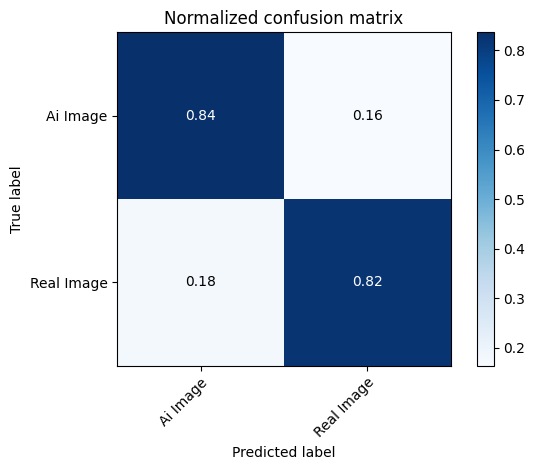

In [ ]:
# Use the model to make predictions on the validation set
model_ft.eval()
y_true = []
y_pred = []
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(class_names.values()), normalize=True,
                      title='Normalized confusion matrix')
plt.show()


Confusion matrix, without normalization
[[87 17]
 [15 69]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

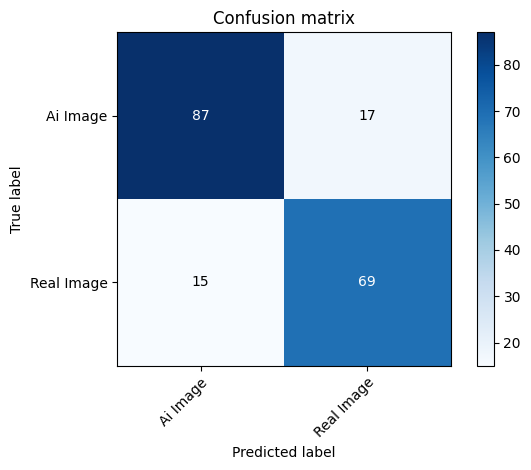

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=list(class_names.values()), normalize=False,
                      title='Confusion matrix')
